In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
from pathlib import Path

method_path = "figs/QSSA/SIM_results/"
mechanism_name = "Otomo_32s213r"

case_name = "case_NH3_counterflow_KAUST"

color_arr = ('k','r','b','y','g', 'c','m')
symbol_arr = ('s','o','v','^','*')
# ─── Use generic serif font ───────────────────────────────────────────────────
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"]   = 7
plt.rcParams["axes.linewidth"] = 0.3   # thinner borders
plt.rcParams["xtick.major.width"] = 0.3
plt.rcParams["ytick.major.width"] = 0.3
plt.rcParams["xtick.minor.width"] = 0.2
plt.rcParams["ytick.minor.width"] = 0.2



# For Ka1p0

yt : [INFO     ] 2025-10-14 20:12:35,875 Parameters: current_time              = 0.03190852139682076
yt : [INFO     ] 2025-10-14 20:12:35,876 Parameters: domain_dimensions         = [ 128  128 1024]
yt : [INFO     ] 2025-10-14 20:12:35,877 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-14 20:12:35,878 Parameters: domain_right_edge         = [0.00582 0.00582 0.04656]


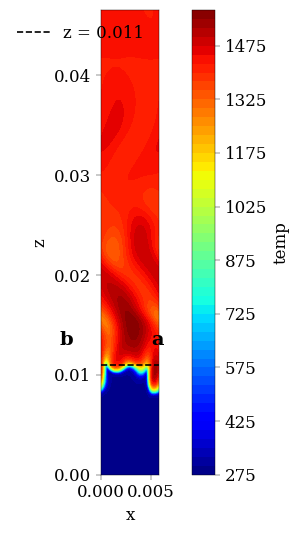

In [2]:
import os
import yt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ---------- Plot style ----------
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "dejavuserif"
rcParams["font.size"] = 12

# ---------- Config ----------
DNS_path     = "cases/H2_DNS/DNSData/Ka1p0/plt09600"
# DNS_path     = "cases/H2_DNS/DNSData/Ka1p0/plt19000"

target_value = "temp"          # or "Y(OH)"
y_idx        = 64              # fixed y-index for plane
z_target     = 0.011           # physical z line to highlight

# ---------- Load dataset ----------
ds  = yt.load(DNS_path)
LE  = ds.domain_left_edge
RE  = ds.domain_right_edge
dims = tuple(int(v) for v in ds.domain_dimensions)  # (nx, ny, nz)

cg = ds.covering_grid(level=0, left_edge=LE, dims=dims)
A = cg[target_value].v  # (nz,ny,nx) or (nx,ny,nz)

def v(a):  # get float from YTArray
    return float(getattr(a, "to_value", lambda: a.d)())

x_min, x_max = v(LE[0]), v(RE[0])
y_min, y_max = v(LE[1]), v(RE[1])
z_min, z_max = v(LE[2]), v(RE[2])

nx, ny, nz = dims

# ---------- Detect layout ----------
if A.ndim == 3 and A.shape == (nz, ny, nx):
    order = ("z","y","x")   # A[z, y, x]
    T2 = A[:, y_idx, :]     # (nz, nx)
elif A.ndim == 3 and A.shape == (nx, ny, nz):
    order = ("x","y","z")   # A[x, y, z]
    T2 = A[:, y_idx, :].T   # (nz, nx)
elif A.ndim == 2 and A.shape == (ny, nx):
    order = ("y","x")
    T2 = A
else:
    raise ValueError(f"Unexpected array shape {A.shape} vs dims {dims}")

# ---------- Coordinates ----------
x = np.linspace(x_min, x_max, nx)
z = np.linspace(z_min, z_max, nz)

# ---------- Plot ----------
plt.figure(figsize=(7, 5.5))
cf = plt.contourf(x, z, T2, levels=50, cmap='jet')
plt.xlabel("x")
plt.ylabel("z")

# Colorbar with units
label = target_value
try:
    units = str(ds.field_info[("boxlib", target_value)].units)
    if units and units != "1":
        label = f"{target_value} [{units}]"
except Exception:
    pass
plt.colorbar(cf, label=label)

# ---------- Add dashed line for z_target ----------
plt.axhline(y=z_target, color='k', linestyle='--', linewidth=1.2, label=f"z = {z_target:.3f}")

# ---------- Annotate 'a' and 'b' in serif font ----------
# adjust coordinates as desired
plt.text(x_min + 0.005, z_target + 0.002, "a", fontsize=14, fontweight='bold', fontfamily='serif')
plt.text(x_max - 0.010, z_target + 0.002, "b", fontsize=14, fontweight='bold', fontfamily='serif')

# ---------- Final touch ----------
plt.legend(loc="upper right", frameon=False)
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()

# Output the 2D csv files

In [ ]:
import os
import yt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd

# ---------- Plot style ----------
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "dejavuserif"
rcParams["font.size"] = 12

# ---------- Config ----------
DNS_path      = "cases/H2_DNS/DNSData/Ka1p0/plt09600"
target_value  = "temp"     # e.g., "temp", "HeatRelease", "Y(OH)"
sections_y    = [64]       # ← list of y-index sections to plot/export
lines_z       = [0.011]    # ← list of physical z positions (m) to highlight & export
levels        = 50
cmap          = "jet"
save_figs     = True
fig_dir       = os.path.join(DNS_path, "figs")
line_csv_dir  = os.path.join(DNS_path, "line_exports")  # unfiltered line CSVs

# ---------- Load dataset ----------
ds  = yt.load(DNS_path)
LE  = ds.domain_left_edge
RE  = ds.domain_right_edge
dims = tuple(int(v) for v in ds.domain_dimensions)  # (nx, ny, nz)
cg   = ds.covering_grid(level=0, left_edge=LE, dims=dims)

A = cg[target_value].v  # could be (nz,ny,nx) or (nx,ny,nz)

def v(a):  # get float from YTArray
    return float(getattr(a, "to_value", lambda: a.d)())

x_min, x_max = v(LE[0]), v(RE[0])
y_min, y_max = v(LE[1]), v(RE[1])
z_min, z_max = v(LE[2]), v(RE[2])
nx, ny, nz = dims

# ---------- Detect layout once ----------
# We’ll wrap slicing in a function that uses the detected layout
if A.ndim == 3 and A.shape == (nz, ny, nx):
    layout = ("z", "y", "x")   # A[z, y, x]
    def slice_y(arr3d, y_idx):
        return arr3d[:, y_idx, :]  # (nz, nx)
    def line_at_kz(arr2d, kz):
        return arr2d[kz, :]  # (nx,)
elif A.ndim == 3 and A.shape == (nx, ny, nz):
    layout = ("x", "y", "z")   # A[x, y, z]
    def slice_y(arr3d, y_idx):
        return arr3d[:, y_idx, :].T  # (nz, nx)
    def line_at_kz(arr2d, kz):
        return arr2d[kz, :]  # still (nx,) because arr2d is (nz,nx)
elif A.ndim == 2 and A.shape == (ny, nx):
    layout = ("y", "x")
    def slice_y(arr2d, y_idx):
        # For truly 2D data, y_idx must match; treat as (nz,nx) with nz=ny
        if arr2d.shape != (ny, nx):
            raise ValueError(f"Unexpected 2D shape {arr2d.shape} vs (ny,nx)=({ny},{nx})")
        return arr2d  # (ny, nx) ≡ (nz, nx)
    def line_at_kz(arr2d, kz):
        return arr2d[kz, :]
else:
    raise ValueError(f"Unexpected array shape {A.shape} vs dims {dims}")

# ---------- Coordinates ----------
x = np.linspace(x_min, x_max, nx)  # (nx,)
z = np.linspace(z_min, z_max, nz)  # (nz,)

# ---------- Units label ----------
label = target_value
try:
    units = str(ds.field_info[("boxlib", target_value)].units)
    if units and units != "1":
        label = f"{target_value} [{units}]"
except Exception:
    pass

# ---------- Ensure output dirs ----------
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(line_csv_dir, exist_ok=True)

# ---------- Helper: nearest z index ----------
def nearest_index(grid_vals, target):
    return int(np.argmin(np.abs(grid_vals - target)))

# ---------- Main loop over y-sections ----------
for y_idx in sections_y:
    # Extract 2D slice (nz, nx) for this y
    S2 = slice_y(A, y_idx)  # (nz, nx)

    # Plot
    plt.figure(figsize=(7, 5.5))
    cf = plt.contourf(x, z, S2, levels=levels, cmap=cmap)
    plt.xlabel("x")
    plt.ylabel("z")
    plt.title(f"{target_value} (y-index = {y_idx})")
    cb = plt.colorbar(cf, label=label)

    # Overlay each requested z line
    for z_line in lines_z:
        kz = nearest_index(z, z_line)
        plt.axhline(y=z[kz], color='k', linestyle='--', linewidth=1.2,
                    label=f"z ≈ {z_line:.6f} (idx {kz})")

        # ----- Export unfiltered line data for this (y_idx, z_line) -----
        line_vals = line_at_kz(S2, kz)  # (nx,)
        df_line = pd.DataFrame({
            "x": x,
            "z": np.full_like(x, z[kz]),
            target_value: line_vals,
            "y_index": np.full_like(x, y_idx, dtype=int)
        })
        out_csv = os.path.join(
            line_csv_dir,
            f"line_y{y_idx:03d}_z{z[kz]:.6f}_{target_value}.csv"
        )
        df_line.to_csv(out_csv, index=False)

    # Legend, aspect, save
    plt.legend(loc="upper right", frameon=False)
    plt.gca().set_aspect("equal", "box")
    plt.tight_layout()

    if save_figs:
        fig_name = os.path.join(fig_dir, f"contour_{target_value}_y{y_idx:03d}.png")
        plt.savefig(fig_name, dpi=300)
        print(f"[ok] Saved figure: {fig_name}")

    plt.show()


yt : [INFO     ] 2025-10-14 20:28:06,743 Parameters: current_time              = 0.03190852139682076
yt : [INFO     ] 2025-10-14 20:28:06,744 Parameters: domain_dimensions         = [ 128  128 1024]
yt : [INFO     ] 2025-10-14 20:28:06,745 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-14 20:28:06,745 Parameters: domain_right_edge         = [0.00582 0.00582 0.04656]


[info] PyArrow path unavailable (No module named 'pyarrow'); using pandas to_csv…
[ok] Saved (pandas) CSV: cases/H2_DNS/DNS2D/raw/H2_pNOX_15_94_TC/DNS_y064_slice_filtered.csv
[ok] Saved (pandas) CSV line: cases/H2_DNS/DNS2D/raw/H2_pNOX_15_94_TC/DNS_y064_z0.011014_line_filtered.csv


# For Ka5p0

yt : [INFO     ] 2025-10-14 20:27:21,709 Parameters: current_time              = 0.011924878906624675
yt : [INFO     ] 2025-10-14 20:27:21,709 Parameters: domain_dimensions         = [ 192  192 3072]
yt : [INFO     ] 2025-10-14 20:27:21,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-14 20:27:21,711 Parameters: domain_right_edge         = [0.00582 0.00582 0.09312]


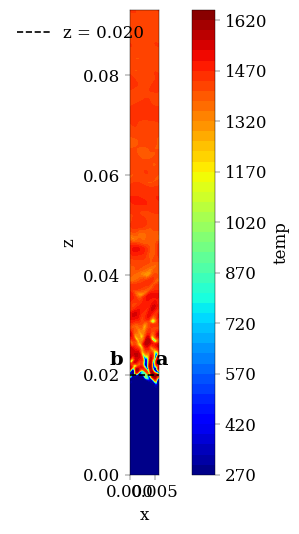

In [4]:
import os
import yt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ---------- Plot style ----------
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "dejavuserif"
rcParams["font.size"] = 12

# ---------- Config ----------
# DNS_path     = "cases/H2_DNS/DNSData/Ka1p0/plt09600"
DNS_path     = "cases/H2_DNS/DNSData/Ka5p0/plt19000"

target_value = "temp"          # or "Y(OH)"
y_idx        = 81              # fixed y-index for plane
z_target     = 0.02           # physical z line to highlight

# ---------- Load dataset ----------
ds  = yt.load(DNS_path)
LE  = ds.domain_left_edge
RE  = ds.domain_right_edge
dims = tuple(int(v) for v in ds.domain_dimensions)  # (nx, ny, nz)

cg = ds.covering_grid(level=0, left_edge=LE, dims=dims)
A = cg[target_value].v  # (nz,ny,nx) or (nx,ny,nz)

def v(a):  # get float from YTArray
    return float(getattr(a, "to_value", lambda: a.d)())

x_min, x_max = v(LE[0]), v(RE[0])
y_min, y_max = v(LE[1]), v(RE[1])
z_min, z_max = v(LE[2]), v(RE[2])

nx, ny, nz = dims

# ---------- Detect layout ----------
if A.ndim == 3 and A.shape == (nz, ny, nx):
    order = ("z","y","x")   # A[z, y, x]
    T2 = A[:, y_idx, :]     # (nz, nx)
elif A.ndim == 3 and A.shape == (nx, ny, nz):
    order = ("x","y","z")   # A[x, y, z]
    T2 = A[:, y_idx, :].T   # (nz, nx)
elif A.ndim == 2 and A.shape == (ny, nx):
    order = ("y","x")
    T2 = A
else:
    raise ValueError(f"Unexpected array shape {A.shape} vs dims {dims}")

# ---------- Coordinates ----------
x = np.linspace(x_min, x_max, nx)
z = np.linspace(z_min, z_max, nz)

# ---------- Plot ----------
plt.figure(figsize=(7, 5.5))
cf = plt.contourf(x, z, T2, levels=50, cmap='jet')
plt.xlabel("x")
plt.ylabel("z")

# Colorbar with units
label = target_value
try:
    units = str(ds.field_info[("boxlib", target_value)].units)
    if units and units != "1":
        label = f"{target_value} [{units}]"
except Exception:
    pass
plt.colorbar(cf, label=label)

# ---------- Add dashed line for z_target ----------
plt.axhline(y=z_target, color='k', linestyle='--', linewidth=1.2, label=f"z = {z_target:.3f}")

# ---------- Annotate 'a' and 'b' in serif font ----------
# adjust coordinates as desired
plt.text(x_min + 0.005, z_target + 0.002, "a", fontsize=14, fontweight='bold', fontfamily='serif')
plt.text(x_max - 0.010, z_target + 0.002, "b", fontsize=14, fontweight='bold', fontfamily='serif')

# ---------- Final touch ----------
plt.legend(loc="upper right", frameon=False)
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
plt.show()

# Cut lines 

In [10]:
import os
import yt
import numpy as np
import pandas as pd

# ---------- Config (Ka5p0) ----------
DNS_path     = "cases/H2_DNS/DNSData/Ka5p0/plt19000"

# batch config
sections_y   = [81]          # list of y-index slices to export as planes
lines_z      = [0.02]        # list of physical z positions (m) to export as lines

oh_thresh    = 1e-8          # reacting-region threshold for plane filtering
use_gzip     = False         # True -> write .csv.gz
output_root  = "cases/H2_DNS/DNS2D/raw/H2_pNOX_15_94_TC"

# ---------- Helpers ----------
def v(a):
    return float(getattr(a, "to_value", lambda: a.d)())

def slice_y(arr3d, dims, y_index):
    nx, ny, nz = map(int, dims)
    if arr3d.ndim == 3 and arr3d.shape == (nz, ny, nx):   # (z,y,x)
        return arr3d[:, y_index, :]                       # (nz,nx)
    elif arr3d.ndim == 3 and arr3d.shape == (nx, ny, nz): # (x,y,z)
        return arr3d[:, y_index, :].T                     # (nz,nx)
    else:
        raise ValueError(f"Unexpected array shape {arr3d.shape} vs dims {dims}")

def get_field_safe(cg, name):
    try:
        return np.asarray(cg[name].v)
    except Exception:
        try:
            return np.asarray(cg[("boxlib", name)].v)
        except Exception:
            return None

def nearest_index(grid_vals, target):
    return int(np.argmin(np.abs(grid_vals - target)))

def to_float32_inplace(df):
    for col in df.columns:
        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(np.float32, copy=False)
    return df

def infer_run_subdir(dns_path):
    # e.g., ".../Ka5p0/plt19000" -> "Ka5p0/plt19000"
    parts = dns_path.strip("/").split("/")
    tail = parts[-2:] if len(parts) >= 2 else [parts[-1]]
    return os.path.join(*tail)

def write_csv_fast(df, out_path):
    """Try pyarrow threaded CSV; fallback to pandas."""
    try:
        import pyarrow as pa
        import pyarrow.csv as pacsv
        table = pa.Table.from_pandas(df, preserve_index=False)
        write_opts = pacsv.WriteOptions(include_header=True, delimiter=",", quoting_style="minimal")
        pacsv.write_csv(table, out_path, write_options=write_opts, use_threads=True)
        print(f"[ok] Saved (pyarrow) CSV: {out_path}")
    except Exception as e:
        print(f"[info] PyArrow unavailable ({e}); using pandas.")
        df.to_csv(out_path, index=False, compression=("gzip" if out_path.endswith(".gz") else None))
        print(f"[ok] Saved (pandas) CSV: {out_path}")

# ---------- Load ----------
ds = yt.load(DNS_path)
LE, RE = ds.domain_left_edge, ds.domain_right_edge
dims   = tuple(int(v) for v in ds.domain_dimensions)
nx, ny, nz = dims
cg = ds.covering_grid(level=0, left_edge=LE, dims=dims)

# Coordinates (for line extraction band)
x_min, x_max = v(LE[0]), v(RE[0])
z_min, z_max = v(LE[2]), v(RE[2])
x = np.linspace(x_min, x_max, nx)
z = np.linspace(z_min, z_max, nz)
Z2, X2 = np.meshgrid(z, x, indexing="ij")  # (nz,nx)

# Gather available fields once
field_names = [f[1] for f in ds.field_list if f[0] == "boxlib"]

# Output dir per run (e.g., H2_pNOX_15_94_TC/Ka5p0/plt19000)
run_subdir  = infer_run_subdir(DNS_path)
output_dir  = os.path.join(output_root, run_subdir)
os.makedirs(output_dir, exist_ok=True)

# ---------- Process each y-section ----------
for y_idx in sections_y:
    # Build unfiltered slice (keep ALL columns)
    slice2d = {"x": X2, "z": Z2}
    for fld in field_names:
        arr = get_field_safe(cg, fld)
        if arr is None:
            continue
        try:
            A2 = slice_y(arr, dims, y_idx)  # (nz,nx)
        except Exception:
            continue
        slice2d[fld] = A2

    data_unf = {k: np.asarray(v).ravel(order="C") for k, v in slice2d.items()}
    df_unfiltered = pd.DataFrame(data_unf)

    # ---------- Plane: filter reacting region (X(OH) or Y(OH)) ----------
    df_plane = df_unfiltered
    if "X(OH)" in df_plane.columns:
        df_plane = df_plane[df_plane["X(OH)"] > oh_thresh]
    elif "Y(OH)" in df_plane.columns:
        df_plane = df_plane[df_plane["Y(OH)"] > oh_thresh]
    else:
        raise KeyError("Neither X(OH) nor Y(OH) present; cannot filter reacting regions.")
    df_plane = df_plane.reset_index(drop=True)

    # Downcast for faster I/O (plane)
    df_plane = to_float32_inplace(df_plane)

    # Save plane CSV (filtered)
    plane_path = os.path.join(
        output_dir,
        f"DNS_y{y_idx:03d}_slice_filtered.csv" + (".gz" if use_gzip else "")
    )
    write_csv_fast(df_plane, plane_path)

    # ---------- Lines at each z in lines_z: UNFILTERED ----------
    # Precompute tolerance for z matching
    tol = 0.5 * (z[1] - z[0]) if len(z) > 1 else 0.0

    for z_line in lines_z:
        kz = nearest_index(z, z_line)
        mask_line = (df_unfiltered["z"] >= z[kz] - tol) & (df_unfiltered["z"] <= z[kz] + tol)
        df_line_unfiltered = df_unfiltered.loc[mask_line].reset_index(drop=True)

        # optional downcast for size/speed
        df_line_unfiltered = to_float32_inplace(df_line_unfiltered)

        line_path = os.path.join(
            output_dir,
            f"DNS_y{y_idx:03d}_z{z[kz]:.6f}_line_unfiltered.csv" + (".gz" if use_gzip else "")
        )
        write_csv_fast(df_line_unfiltered, line_path)

print("[done] Exported planes (filtered) and lines (unfiltered).")


yt : [INFO     ] 2025-10-14 23:34:39,337 Parameters: current_time              = 0.011924878906624675
yt : [INFO     ] 2025-10-14 23:34:39,337 Parameters: domain_dimensions         = [ 192  192 3072]
yt : [INFO     ] 2025-10-14 23:34:39,338 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-14 23:34:39,339 Parameters: domain_right_edge         = [0.00582 0.00582 0.09312]


[info] PyArrow unavailable ("minimal" is not a valid quoting style); using pandas.
[ok] Saved (pandas) CSV: cases/H2_DNS/DNS2D/raw/H2_pNOX_15_94_TC/Ka5p0/plt19000/DNS_y081_slice_filtered.csv
[info] PyArrow unavailable ("minimal" is not a valid quoting style); using pandas.
[ok] Saved (pandas) CSV: cases/H2_DNS/DNS2D/raw/H2_pNOX_15_94_TC/Ka5p0/plt19000/DNS_y081_z0.020013_line_unfiltered.csv
[done] Exported planes (filtered) and lines (unfiltered).


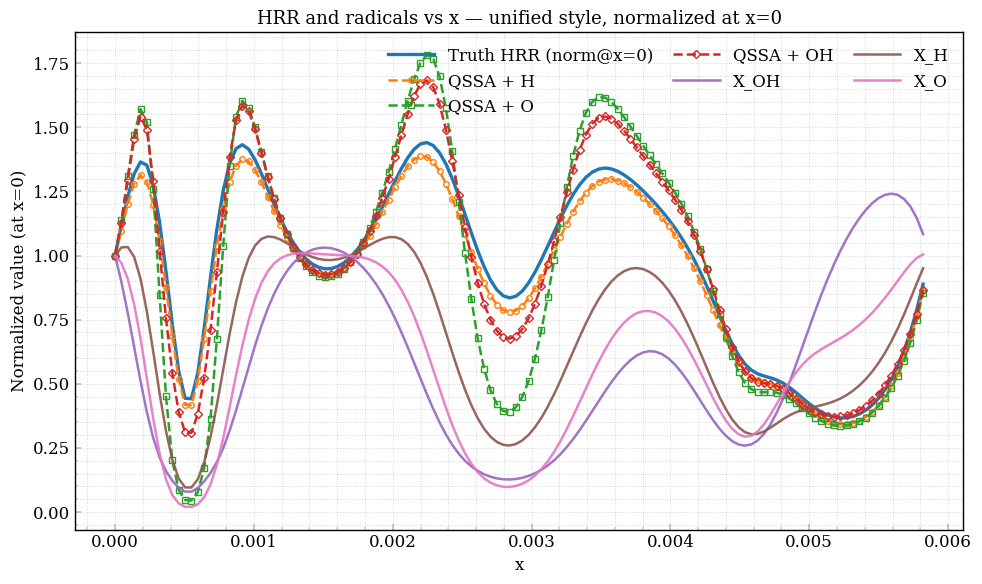

Saved to figs/DNS/line_y064_z0p011_HRR_species_all_normAt0.png


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# ── Global style (unified) ─────────────────────────────────────────────────────
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "axes.linewidth": 1.0,
    "lines.linewidth": 1.8,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "xtick.minor.size": 2,
    "ytick.minor.size": 2,
    "legend.frameon": False,
})

# ── Paths ─────────────────────────────────────────────────────────────────────
truth_csv = "cases/H2_DNS/DNSLine/Ka1p0/plt9600/processed/H2_pNOX_15_94_TC/line_y064_z0p011_all.csv"
pred_withH_csv  = "cases/H2_DNS/DNSLine/Ka1p0/plt9600/Sim_QSSA_withH/H2_pNOX_15_94_TC/line_y064_z0p011_all/predicted_X.csv"
pred_withO_csv  = "cases/H2_DNS/DNSLine/Ka1p0/plt9600/Sim_QSSA_withO/H2_pNOX_15_94_TC/line_y064_z0p011_all/predicted_X.csv"
pred_withOH_csv = "cases/H2_DNS/DNSLine/Ka1p0/plt9600/Sim_QSSA_withOH/H2_pNOX_15_94_TC/line_y064_z0p011_all/predicted_X.csv"
mech_path = "mechanism/H2_pNOX_15_94_TC.yaml"

save_png = "figs/DNS/line_y064_z0p011_HRR_species_all_normAt0.png"
os.makedirs(os.path.dirname(save_png), exist_ok=True)

# ---------- Helpers ----------
def sort_by_x(df, xcol="x"):
    if xcol not in df.columns:
        raise KeyError(f"Column '{xcol}' not found in DataFrame.")
    return df.sort_values(xcol).reset_index(drop=True)

def _interp_at(x, y, x0):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    idx = np.argsort(x)
    return np.interp(x0, x[idx], y[idx])

def normalize_series_at_x0(x, y, x0=0.0, eps=1e-30):
    denom = _interp_at(x, y, x0)
    if abs(denom) < eps:
        denom = eps
    return y / denom, denom

def get_species_series(df, species, prefer="X"):
    xname = f"X_{species}"
    yname = f"Y_{species}"
    if prefer == "X" and xname in df.columns:
        return xname, df[xname]
    if yname in df.columns:
        return yname, df[yname]
    if xname in df.columns:
        return xname, df[xname]
    raise KeyError(f"Neither {xname} nor {yname} found in DataFrame.")

# ---------- Load & sort ----------
truth = sort_by_x(pd.read_csv(truth_csv))
predH = sort_by_x(pd.read_csv(pred_withH_csv))
predO = sort_by_x(pd.read_csv(pred_withO_csv))
predOH = sort_by_x(pd.read_csv(pred_withOH_csv))

xcol = "x"
x_truth = truth[xcol].values

# Sanity check
for name, df in [("truth", truth), ("pred_withH", predH), ("pred_withO", predO), ("pred_withOH", predOH)]:
    if "HRR" not in df.columns:
        raise KeyError(f"'HRR' column missing in {name} DataFrame.")

# ---------- Normalize HRR ----------
x0 = 0.0
truth["HRR_norm"], _  = normalize_series_at_x0(truth[xcol], truth["HRR"], x0)
predH["HRR_norm"], _  = normalize_series_at_x0(predH[xcol], predH["HRR"], x0)
predO["HRR_norm"], _  = normalize_series_at_x0(predO[xcol], predO["HRR"], x0)
predOH["HRR_norm"], _ = normalize_series_at_x0(predOH[xcol], predOH["HRR"], x0)

# ---------- Normalize Species ----------
sp_names = ["OH", "H", "O"]
species_series = []
for sp in sp_names:
    cname, series = get_species_series(truth, sp, prefer="X")
    y_norm, _ = normalize_series_at_x0(x_truth, series.values, x0)
    species_series.append((sp, cname, y_norm))

# ---------- Styles ----------
tab = plt.get_cmap("tab10").colors
style = {
    "truth_hrr": dict(color=tab[0], lw=2.4, linestyle="-"),
    "qssa_h":    dict(color=tab[1], lw=1.8, linestyle="--",
                      marker="o", markersize=4, markerfacecolor="none"),
    "qssa_o":    dict(color=tab[2], lw=1.8, linestyle="--",
                      marker="s", markersize=4, markerfacecolor="none"),
    "qssa_oh":   dict(color=tab[3], lw=1.8, linestyle="--",
                      marker="D", markersize=4, markerfacecolor="none"),
    "X_OH":      dict(color=tab[4], lw=1.8, linestyle="-", alpha=0.9),
    "X_H":       dict(color=tab[5], lw=1.8, linestyle="-", alpha=0.9),
    "X_O":       dict(color=tab[6], lw=1.8, linestyle="-", alpha=0.9),
}

# ---------- Plot ----------
fig, ax = plt.subplots(figsize=(10, 6))

# HRR curves
ax.plot(truth[xcol], truth["HRR_norm"], label="Truth HRR (norm@x=0)", **style["truth_hrr"])
ax.plot(predH[xcol],  predH["HRR_norm"],  label="QSSA + H",  **style["qssa_h"])
ax.plot(predO[xcol],  predO["HRR_norm"],  label="QSSA + O",  **style["qssa_o"])
ax.plot(predOH[xcol], predOH["HRR_norm"], label="QSSA + OH", **style["qssa_oh"])

# Species curves
for sp, cname, arr_norm in species_series:
    key = cname  # e.g., "X_OH"
    ax.plot(x_truth, arr_norm, label=f"{cname}", **style.get(key, dict(lw=1.8)))

# Cosmetics
ax.set_xlabel("x")
ax.set_ylabel("Normalized value (at x=0)")
ax.set_title("HRR and radicals vs x — unified style, normalized at x=0")
ax.grid(True, which="both", ls=":", lw=0.6, alpha=0.6)
ax.minorticks_on()

# Legend fix — use correct handle attribute name
leg = ax.legend(ncols=3, handlelength=2.8, columnspacing=1.2, borderaxespad=0.5)
handles = getattr(leg, "legend_handles", getattr(leg, "legendHandles", []))
for h in handles:
    try:
        h.set_markerfacecolor("none")
    except Exception:
        pass

fig.tight_layout()
fig.savefig(save_png, dpi=300)
plt.show()

print(f"Saved to {save_png}")